# Race and Gender Effect on Income

## Introduction

Visual characteristics are not something that one often considers as strong determinants of what their salary will be when looking for a job. Despite this, it is well known that there are pay gaps in all countries throughout the world due to these things. This being a popular discussion over the few last decades, we are interested in determining the validity of claims for and against the existence of these harsh truths in society. Today we want to answer the question: are visual characteristics like race and gender a good indicator of income? To answer this question we will look at census data collected in the USA in 1994. The data provides info on citizens concerning many areas like education, hours worked per week, race, gender, occupation, income and more. We will use this data to make predictions on whether or not a person's income exceeds $50k, specifically looking at whether visual characteristics as described above can play an important role in our prediction. The census data, although 30 years old as of 2024, can provide a snapshot of what society was like at that time.

## Preliminary Data Analysis

### 1. Loading data from the web and cleaning it

In this section we simply obtain the url containing our dataset of choice, add relevant column names to our data, and convert it from a csv to a dataframe.

In [1]:
# Install and load the necessary libraries
library(readr)
library(tidyverse)
library(tidymodels)
library(forcats)
library(knitr)

options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::

In [2]:
# Define the URL for the Census Income dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Define column names
column_names <- c("age", "workclass", "fnlwgt", "education", "education_num", 
                  "marital_status", "occupation", "relationship", "race", 
                  "sex", "capital_gain", "capital_loss", "hours_per_week", 
                  "native_country", "income")


# Read the Census Income dataset into a dataframe
census_data <- read.csv(url, header = FALSE, col.names = column_names)

census_data <- census_data %>%
  mutate(across(c("workclass","education","marital_status","occupation","relationship","race", "sex","native_country","income"), as_factor))

# Display the first few rows of the dataframe
head(census_data)
tail(census_data)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32561,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


### 2. Summarizing our dataset

In this section we create our initial test and train splits. We then produce a few tables to summarize our data including grouping by income, sex and race to see the representation within our data set, as well the mean values for a few columns when grouped into the same categories, and finally a report of the number of rows with missing data.

In [3]:
set.seed(2024)
# Create test and train splits
census_split <- initial_split(census_data, prop = 0.75, strata = income)
census_training <- training(census_split)
census_testing <- testing(census_split)
census_vfold <- vfold_cv(census_training, v = 3, strata = income)


In [4]:
summary_table <- census_training %>%
  group_by(income, sex, race) %>%
  summarize(count = n())

# Display the summary table, print them for better readability
cat("\nTable 1: Summary Table\n")
print(kable(summary_table, caption = "Summary Table"))

# Produce means for age, education_num, hours_per_week (vars we will likely use)
means_table <- census_training %>%
  group_by(income, sex, race) %>%
  summarize(
    mean_age = mean(age),
    mean_education_num = mean(education_num),
    mean_hours_per_week = mean(hours_per_week)
  )

# Display the means table
cat("\nTable 2: Means Table\n")
print(kable(means_table, caption = "Means Table"))

# Find the number of rows with missing values
missing_rows_training <- census_training %>%
  summarise_all(~sum(is.na(.)))

# Display the number of rows with missing values
cat("\nTable 3: Number of Rows with Missing Values\n")
print(kable(missing_rows_training, caption = "Number of Rows with Missing Values"))

`summarise()` has grouped output by 'income', 'sex'. You can override using the
`.groups` argument.



Table 1: Summary Table


Table: Summary Table

|income |sex    |race               | count|
|:------|:------|:------------------|-----:|
|<=50K  |Male   |White              |  9816|
|<=50K  |Male   |Black              |   954|
|<=50K  |Male   |Asian-Pac-Islander |   335|
|<=50K  |Male   |Amer-Indian-Eskimo |   126|
|<=50K  |Male   |Other              |    99|
|<=50K  |Female |White              |  5704|
|<=50K  |Female |Black              |  1133|
|<=50K  |Female |Asian-Pac-Islander |   217|
|<=50K  |Female |Amer-Indian-Eskimo |    79|
|<=50K  |Female |Other              |    77|
|>50K   |Male   |White              |  4566|
|>50K   |Male   |Black              |   224|
|>50K   |Male   |Asian-Pac-Islander |   167|
|>50K   |Male   |Amer-Indian-Eskimo |    16|
|>50K   |Male   |Other              |    18|
|>50K   |Female |White              |   775|
|>50K   |Female |Black              |    69|
|>50K   |Female |Asian-Pac-Islander |    32|
|>50K   |Female |Amer-Indian-Eskimo |     9|
|>50K  

`summarise()` has grouped output by 'income', 'sex'. You can override using the
`.groups` argument.



Table 2: Means Table


Table: Means Table

|income |sex    |race               | mean_age| mean_education_num| mean_hours_per_week|
|:------|:------|:------------------|--------:|------------------:|-------------------:|
|<=50K  |Male   |White              | 37.27863|           9.471068|            40.96852|
|<=50K  |Male   |Black              | 35.84067|           9.075472|            38.68763|
|<=50K  |Male   |Asian-Pac-Islander | 37.17910|          10.417910|            39.58806|
|<=50K  |Male   |Amer-Indian-Eskimo | 36.67460|           8.976190|            41.63492|
|<=50K  |Male   |Other              | 33.09091|           8.484849|            41.52525|
|<=50K  |Female |White              | 36.06241|           9.901823|            35.88289|
|<=50K  |Female |Black              | 37.65225|           9.474846|            36.54281|
|<=50K  |Female |Asian-Pac-Islander | 33.95392|          10.580645|            36.92166|
|<=50K  |Female |Amer-Indian-Eskimo | 35.27848|           9.443038

### 3. Visualizing our dataset

Here we plot the distribution of gender by race and by age to get a better understanding of the majority and minority groups within our data.

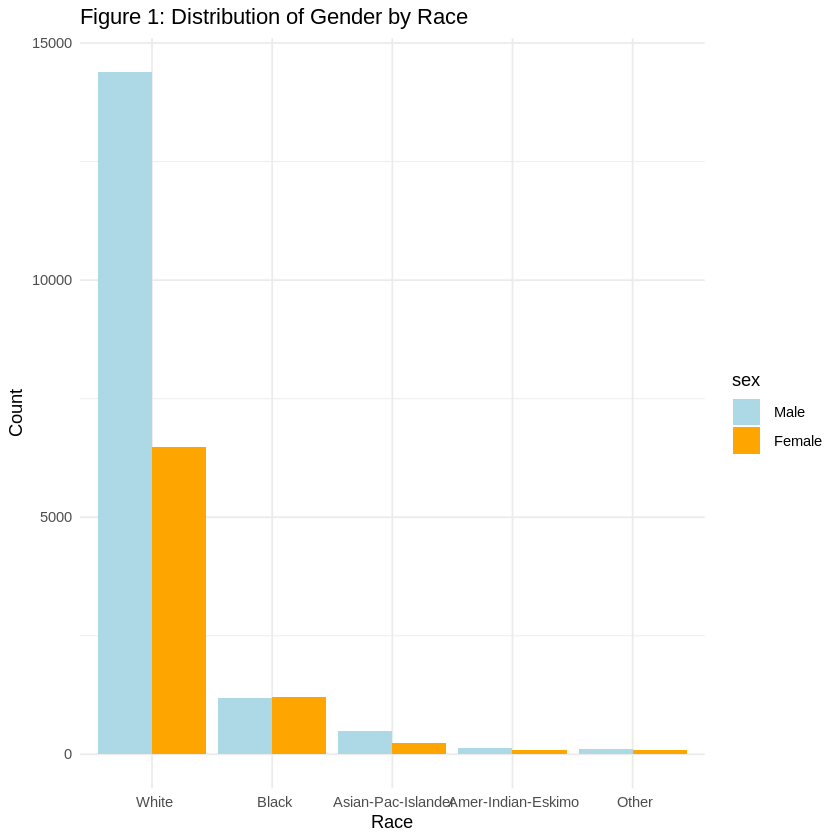

In [5]:
# Create a bar plot to identify distribution of race by gender in our dataset
gener_by_race_plot <- ggplot(census_training, aes(x = race, fill = sex)) +
  geom_bar(position = "dodge", stat = "count") +
  labs(title = "Figure 1: Distribution of Gender by Race",
       x = "Race",
       y = "Count") +
  scale_fill_manual(values = c("lightblue", "orange")) +
  theme_minimal()

gener_by_race_plot

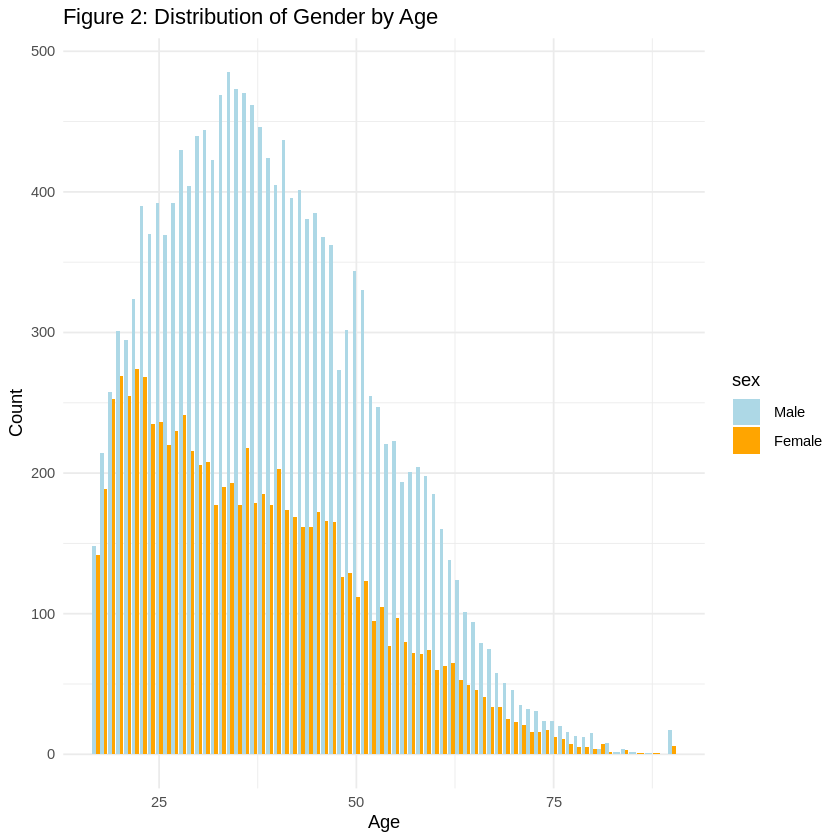

In [6]:
# Create a bar plot to identify distribution of ager by gender in our dataset
gender_by_age_plot <- ggplot(census_training, aes(x = age, fill = sex)) +
  geom_bar(position = "dodge", stat = "count") +
  labs(title = "Figure 2: Distribution of Gender by Age",
       x = "Age",
       y = "Count") +
  scale_fill_manual(values = c("lightblue", "orange")) +
  theme_minimal()

gender_by_age_plot

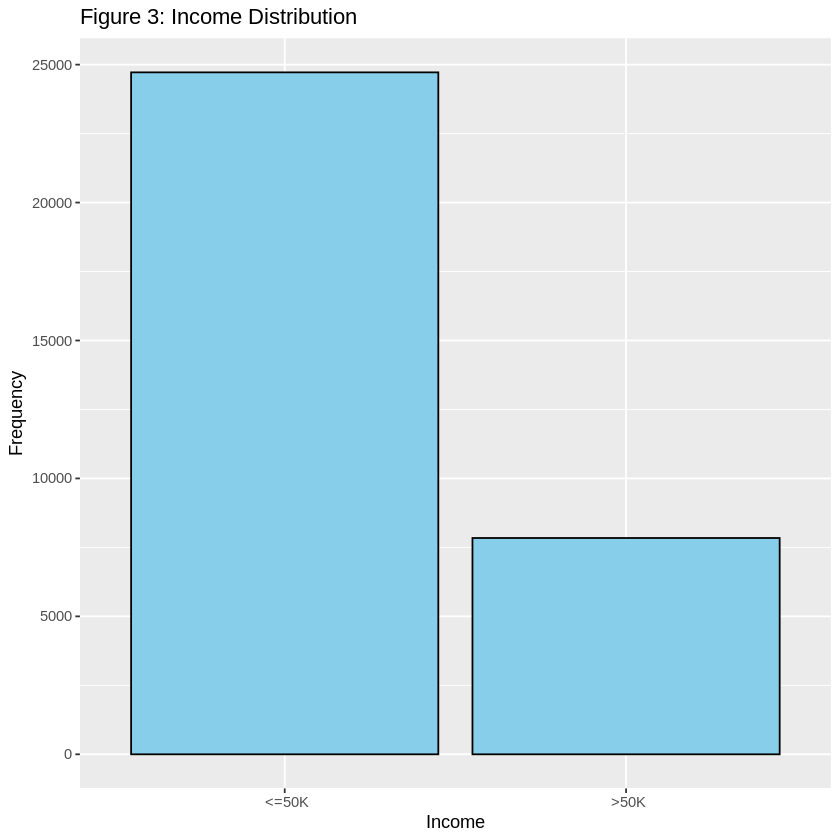

In [7]:
ggplot(census_data, aes(x = income)) +
  geom_bar(fill = "skyblue", color = "black") +
  labs(title = "Figure 3: Income Distribution",
       x = "Income",
       y = "Frequency")

### 4. Remarks on our data 

From our preliminary analysis we note that their is an overrepresentation of caucasian people in our data, as well as an overrepresentation of males. Despite this, the amount of data we have is still large when concerning other races and gender so we will proceed with our analysis. Further, we not that their is a class imbalance in the target variable, income. To account for this we use the step_upscale() function to make both income cases roughly equally represented. We also note that we have no missing data in any rows.

## Analysis

We will conduct our analysis by creating a baseline model without using race or gender as factors. We will then conduct an ablation study where we include one or both of the factors and see if this improves accuracy of our model. 

### Steps of this analysis are outlined below:
1. Create a baseline k means classifcation method using characteristics outside of race and gender to obtain an optimized baseline accuracy. (We will use age, education number).
2. Redo testing and optimization when including race, gender as factors.
3. Compare results between the 3 test configurations and look for trends.

### 1. Creating the baseline model (BL)

In [8]:
census_recipe_BL <- recipe(income ~ age + hours_per_week, data = census_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [9]:
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

In [10]:
gridvals <- tibble(neighbors = seq(from = 1, to = 101, by = 10))

In [ ]:
knn_fit <- workflow() |>
    add_recipe(census_recipe_BL) |>
    add_model(knn_tune) |>
    tune_grid(resamples = census_vfold, grid = gridvals)

In [ ]:
knn_results <- collect_metrics(knn_fit)

In [ ]:
accuracies <- knn_results |>
    filter(.metric == 'accuracy')

In [ ]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Neighbors', y = 'Accuracy Estimates') +
    ggtitle('Figure 4: Neighbors vs Accuracy Estimates for Base Line Model')

accuracy_vs_k

From the above graph, we can see that a k value of 41 is preferable for this configuration. 

In [ ]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 41) |>
    set_engine('kknn') |>
    set_mode('classification')

In [ ]:
knn_fit_BL <- workflow() |>
    add_recipe(census_recipe_BL) |>
    add_model(knn_spec) |>
    fit(data = census_training)

In [ ]:
census_predictions <- predict(knn_fit_BL, census_testing) |>
    bind_cols(census_testing)

In [ ]:
census_metrics_baseline <- census_predictions |>
    metrics(truth = income, estimate = .pred_class)
census_metrics_baseline

In [ ]:
plot1 <- ggplot(census_predictions, aes(x = age, y = hours_per_week, color = .pred_class)) +
  geom_point() +
  labs(title = "Age vs. Hours per Week",
       x = "Age",
       y = "Hours per Week",
       color = "Income Prediction")

#### Results for Base Line Model

From our base line model including data on only age and number of hours worked per week, we see an accuracy of 76.16%.

### 2. Obtaining Results with Race included as a factor

In [ ]:
census_recipe_R <- recipe(income ~ age + hours_per_week + race, data = census_training) |>
    step_scale(age, hours_per_week) |>
    step_center(age, hours_per_week)

In [ ]:
gridvals <- tibble(neighbors = seq(from = 1, to = 101, by = 10))

In [ ]:
knn_fit_R <- workflow() |>
    add_recipe(census_recipe_R) |>
    add_model(knn_tune) |>
    tune_grid(resamples = census_vfold, grid = gridvals)

In [ ]:
knn_results <- collect_metrics(knn_fit_R)

In [ ]:
accuracies <- knn_results |>
    filter(.metric == 'accuracy')

In [ ]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Neighbors', y = 'Accuracy Estimates') +
    ggtitle('Figure 5: Neighbors vs Accuracy Estimates for Model Including Race')

accuracy_vs_k

From the above graph, we can see that a k value of 41 is preferable for this configuration. 

In [ ]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 41) |>
    set_engine('kknn') |>
    set_mode('classification')

In [ ]:
knn_fit <- workflow() |>
    add_recipe(census_recipe_R) |>
    add_model(knn_spec) |>
    fit(data = census_training)

In [ ]:
census_predictions <- predict(knn_fit, census_testing) |>
    bind_cols(census_testing)

In [ ]:
census_metrics_race <- census_predictions |>
    metrics(truth = income, estimate = .pred_class)
census_metrics_race

#### Results for Model including Race

From our model including data on age, number of hours worked per week, and race, we see an accuracy of 76.1%. This is a slight decrease showing race did not help predict income.

In [ ]:
fig6 <- ggplot(census_predictions, aes(x = age, y = hours_per_week, color = .pred_class)) +
  geom_point() +
  labs(title = "Figure 6: Age vs. Hours Worked per Week",
       x = "Age",
       y = "Hours per Week",
       color = "Income Prediction")
fig6

In [ ]:
fig7 <- ggplot(census_predictions, aes(x = age, color = .pred_class)) +
  geom_point(aes(y = as.numeric(race))) +
  scale_y_continuous(breaks = 1:5, labels = levels(census_predictions$race)) +
  labs(title = "Figure 7: Age vs. Race, Predicted Income",
       x = "Age",
       y = "Race",
       color = "Income Prediction")
fig7

In [ ]:
fig8 <- ggplot(census_predictions, aes(x = age, color = income)) +
  geom_point(aes(y = as.numeric(race))) +
  scale_y_continuous(breaks = 1:5, labels = levels(census_predictions$race)) +
  labs(title = "Figure 8: Age vs. Race, Actual Income",
       x = "Age",
       y = "Race",
       color = "Actual Income")
fig8

### 3. Obtaining Results with Sex included as a factor

In [ ]:
census_recipe_S <- recipe(income ~ age + hours_per_week + sex, data = census_training) |>
    step_scale(age, hours_per_week) |>
    step_center(age, hours_per_week)

In [ ]:
gridvals <- tibble(neighbors = seq(from = 1, to = 101, by = 10))

In [ ]:
knn_fit_S <- workflow() |>
    add_recipe(census_recipe_S) |>
    add_model(knn_tune) |>
    tune_grid(resamples = census_vfold, grid = gridvals)

In [ ]:
knn_results <- collect_metrics(knn_fit_S)

In [ ]:
accuracies <- knn_results |>
    filter(.metric == 'accuracy')

In [ ]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Neighbors', y = 'Accuracy Estimates') +
    ggtitle('Figure 9: Neighbors vs Accuracy Estimates for Model Including Sex')

accuracy_vs_k

From the above graph, we can see that a k value of 31 is preferable for this configuration. 

In [ ]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 31) |>
    set_engine('kknn') |>
    set_mode('classification')

In [ ]:
knn_fit <- workflow() |>
    add_recipe(census_recipe_S) |>
    add_model(knn_spec) |>
    fit(data = census_training)

In [ ]:
census_predictions <- predict(knn_fit, census_testing) |>
    bind_cols(census_testing)

In [ ]:
census_metrics_sex <- census_predictions |>
    metrics(truth = income, estimate = .pred_class)
census_metrics_sex

#### Results for Model including Sex

From our model including data on age, number of hours worked per week, and sex, we see an accuracy of 76.56%. A slight increase showing sex may be a useful indicator of income.

In [ ]:
fig10 <- ggplot(census_predictions, aes(x = age, y = hours_per_week, color = .pred_class)) +
  geom_point() +
  labs(title = "Figure 10: Age vs. Hours per Week, Predicted Income",
       x = "Age",
       y = "Hours per Week",
       color = "Income Prediction")
fig10

In [ ]:
fig10 <- ggplot(census_predictions, aes(x = age, color = .pred_class)) +
  geom_point(aes(y = as.numeric(sex))) +
  scale_y_continuous(breaks = c(0, 1), labels = c("Female", "Male")) +
  labs(title = "Figure 10: Age vs. Sex, Predicted Income",
       x = "Age",
       y = "Sex",
       color = "Income Prediction")
fig10

In [ ]:
fig11 <- ggplot(census_predictions, aes(x = age, color = income)) +
  geom_point(aes(y = as.numeric(sex))) +
  scale_y_continuous(breaks = c(0, 1), labels = c("Female", "Male")) +
  labs(title = "Figure 11: Age vs. Sex, Actual Income",
       x = "Age",
       y = "Sex",
       color = "Actual Income")
fig11

#### A quick summary of findings:

In [ ]:
census_metrics_baseline
census_metrics_race
census_metrics_sex

- The best results occured when we used sex as a factor
- The worst results occured when we used race as a factor
- Changes in accuracy in either case were small, suggesting the class imbalance may be too strong for this dataset

## Discussion

Through our analysis we found that sex may be a useful factor to consider when predicting individuals income in the USA in 1994. We also found that race may not be a useful factor. We say maybe becuase the changes in accuracy of our knn classification were minimal. When we plotted age versus sex and looked at the actual and predicted income, we noticed that the algorithm predicted 0 females in the testing set to have income greater than $50k, showing that a bias is clearly introduced by incorporating sex as a factor. In general we did expect to find an outcome similar to this, at least one showing that sex would allow our algorithm to achieve greater accuracy, since we do think that gender bias would exist in this dataset. However we also thought that race would have an effect, but it did not. 

The impact of these findings could be used to discuss the gender pay gap and prove that its existance in real world datasets confirms that it is a real issue. These findings could be presented in workplace training workshops discussing matters related to equity and diversity. This could also aid in the development of hiring policies relating to fairness and employee rights protection. It is however important to note that this data is 30 years old as of 2024. 

These findings could lead to a few questions:
- If we looked at data from 2024, would this effect still occur? To the same magnitude?
- Do algorithms used today in a similar manner for a similar task contain these biases as well?
- What can we do to avert these biases?

## References

GfG. (2023, December 20). KNN classifier in R programming. GeeksforGeeks. https://www.geeksforgeeks.org/k-nn-classifier-in-r-programming/ 
Almlund, M., Bütikofer, A., Cobb-Clark, D. A., Fortin, N., Gensowski, M., Heineck, G., Nyhus, E. K., Oaxaca, R., Oberfichtner, M., Albrecht, J., Altonji, J. G., Angelov, N., Angrist, J. D., … Castagnetti, C. (2022, July 8). The gender pay gap revisited: Does machine learning offer new insights?. Labour Economics. https://www.sciencedirect.com/science/article/abs/pii/S0927537122001130#:~:text=We%20use%20machine%20learning%20to,should%20be%20used%20for%20estimation. 